# Module 7 -- Ensemble Learning and Random Forests

This material is adapted from the book Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow by Geron Aurelien.


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Ensemble Learning and Random Forests

* Often, a group of predictions can yield better results than a single very good prediction.

* A group of predictors is called an `ensemble`

* We have seen an example of this - a group of Decision Tree classifiers can be put together into a Random Forest classifier.

* Ensemeble methods let us put different types of classifiers together

* Ensemeble methods are often used toward the end of a project, after we already have a few good predictors

* We will look at the following ensemble methods:
    * bagging
    * boosting
    * stacking



# Voting Classifiers

Suppose you have trained some classifiers, each achieving about 80% accuracy:

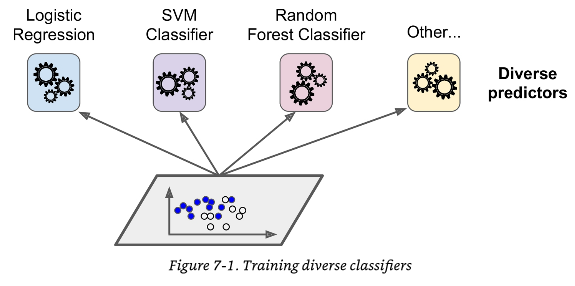

One way to combine these is to aggregate the predictions of each classifier.

And then predict the class that gets the most votes.

This is called a hard voting classifier:

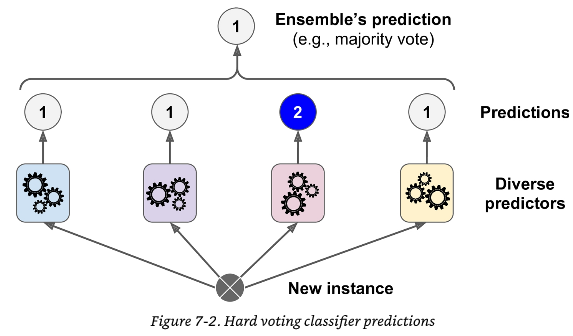


Often, a voting classifier will perform better than the best single classifier in the model.



#### Why does this work, even with weak learners?

Suppose you have coin that is slightly biased - it has a 51% chance of heads and 49% chance of tails.

If you toss this coin 1000 times, we would estimate that on average:
* 510 times it will be heads
* 490 times it will be tails

If you repeated this experiment (1000 tosses) many times, the probabiliy that a majority of the tosses would be heads is close to 75%.

Similarly, if you had 1000 binary classifiers that were only correct 51% of the time

If you predicted the majority voted class, you would hope for up to 75% accuracy.

However, this would assume that all the classifiers were perfectly indepdent, making uncorrelated errors.

This is not the case since they were all trained on the same data.

Thus, they are likely to make the same types of errors, reducing the overall accuracy of the ensemble.

One way to get diverse classifiers is to train them using very different algorithms, increasing the chance that they will make different types of errors.


### Ensemble example

Let's look at an example using the moons dataset:

First, we will create the data:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Next, we will set up three classifiers into an ensemble:

* A logistic regression classifier
* A random forest classifier
* A support vector machine classifier

To create the ensemble, we will use the scikit-learn class `VotingClassifier`:
* we pass it a list of the classifiers we wish to use in the ensemble
* and indicate what type of voting we wish to use (in this case we will use hard voting)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

Next, we will train the voting classifier:

In [ ]:
voting_clf.fit(X_train, y_train)

And then we can compute the accuracy scores for each classifier individually and the accuracy of the VotingClassifier ensemble:

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

**Note**: the results in this notebook may differ slightly from the book, as Scikit-Learn algorithms sometimes get tweaked.

As you can see, the ensemble VotingClassifier outperforms the individual classifiers.

### Soft voting

If all the classifiers can estimate class probabilities (e.g., they have a predict_proba() method)

Then you can use soft voting to have scikit-learn predict the class with the highest class probability, averaged over all the classifiers.

This will give more weight to highly confident votes.

In our example, the SVC class does not predict class probabilities by default, but will do so if we set `probability=True`.

Here is the code to use soft voting with our moon data example:

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

We can see here that soft voting slightly outperforms hard voting for this example.

# Bagging and Pasting

Above, to get a diverse set of classifiers for our ensemble we used *different* classifiers.

Another approach to get diversity is to use the same classification algorithm, but train separate classifiers on different random subsets of the training set.

* Bagging -- when you do this method with replacement, it is called bagging, or bootstrap aggregating
* Pasting -- when you do this method without replacement, it is called pasting

Both bagging and pasting allow training instances to be sampled multiple times *across multiple predictors*.

However, only bagging allows training instances to be sampled multiple times for the same predictor (e.g. classifier).

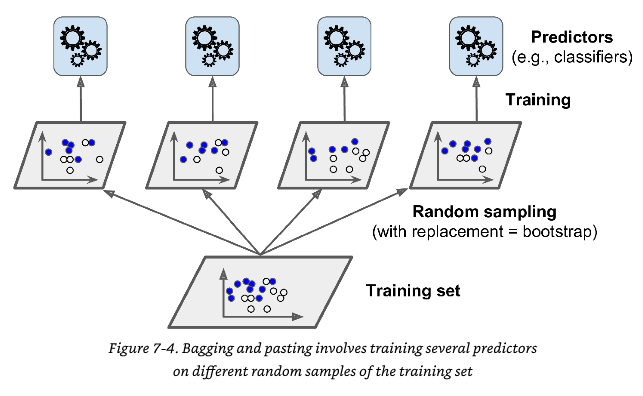


In general, each individual predictor will have a higher bias than if it was trained on the original training set.

However, the aggregation reduces both the bias and variance.

Generally, the result is that the ensemble has similar bias but lower variance than a single predictor trained on the original data set.


#### Training in parallel

Another advantage of bagging and pasting is that the predictors can be trained in parallel, using diffferent CPU cores.

This means that these methods can scale well.



## Bagging and Pasting in Scikit-Learn

scikit-learn has a simple class for bagging and pasting called `BaggingClassifier`

There is also a `BaggingRegressor` for regression.

The code below creates an ensemble of 500 DecisionTree classifiers, each trained on a random subset of 100 instances from the training set -- with replacement (so this is bagging).

A pasting version could be created by setting `bootstrap=False`

BaggingClassifier automatically uses soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., it has a predict_proba() method).

Since DecisionTrees do have a predict_proba() method, the ensemble below uses soft voting.


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Next, we can check the accuracy of the predictions from the ensemble:

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

And compare it to the accuracy of the predictions from a single DecisionTreeClassifier trained on the entire training set:

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

#### Ensemble versus single DecisionTree

The figure below shows a comparison of the decision boundary of a single DecisionTree versus the decision boundary of a bagging ensemble of 500 trees (from the code above, trained on the moons dataset):

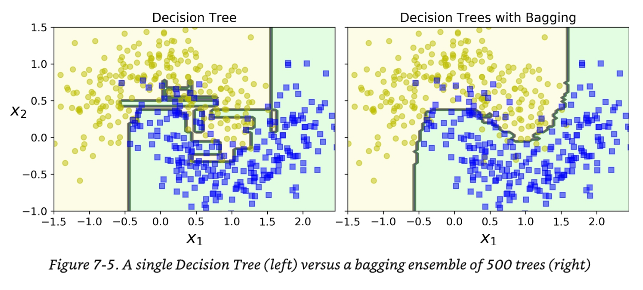

The ensemble's predictions will likely generalize much better.
* the ensemble has a comparable bias, but a smaller variance
    * (it makes roughly the same number of errors, but the decision boundary is less irregular)
    

#### Bagging versus pasting

Bootstrapping introduces a bit more diversity in the subsets.

This means that typically bagging ends up with slightly higher bias than pasting

However, the diversity means that the individual predictors are less correlated, so the ensemble's variance is reduced.

Overall, bagging usually results in better models and is preferred.



## Out-of-Bag evaluation

With bagging, some instances are sampled several times for a given predictor, while other instances may not be sampled at all.

The instances that are not sampled at all are called *out-of-bag* (oob) instances.

They can be used to evaluate a bagging ensemble without the need for a separate validation set.

If you have enough estimators, it is likely that each instance in the training set will be an oob instance for several estimators.

In scikit-learn, you can set `oob_score=True` for a `BaggingClassifier` to get an automatic oob evaluation after training.

The resulting evaluation score is available in the `oob_score_variable`

This score is an *estimate* of the expected accuracy.


In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

You can also get the class probabilities for each training instance from the `oob_decision_function_variable`:

In [ ]:
bag_clf.oob_decision_function_

We can compare the oob estimated accuracy with the accuracy we get by evaluating the classifier on the test set:

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

# Boosting

The idea behind boosting is to use an ensemble to train predictors sequentially, each trying to correct errors made by its predecessor.

We will briefly look at two methods:

* adaptive boosting (or adaboost)
* gradient boosting





## AdaBoost

In AdaBoost, each subsequent predictor tries to correct the errors of its predecessor by paying more attention to the training instances that the predecessor underfitted.

In other words, the new predictors focus on the harder cases.


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

## Gradient Boosting

Let create a simple quadratic dataset:

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred